Rerun NATMI with outliers removed

In [2]:
library(Seurat)

library(dplyr)
library(tidyr)
library(stringr)

library(ggplot2)
library(gridExtra)
library(ggpubr)
library(viridis)
library(ComplexHeatmap)
library(circlize)
library(ggrepel)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(

In [3]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS/LAPACK: /mnt/volume1/env/miniconda3/envs/r4.1.0/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.9.1        circlize_0.4.13      ComplexHeatmap_2.8.0
 [4] viridis_0.6.1        viridisLite_0.4.0    ggpubr_0.4.0        
 [7] gridExtra_2.3        ggplot2_3.3.5        stringr_1.4.0       
[10] tidyr_1.1.3          dplyr_1.0.7          SeuratObject_4.0.2  
[13] Seurat_4.0.3        

loaded via a namespace (and not attached):
  

# Load data

In [4]:
sc <- readRDS("../data/venDG2021outlierrem_seurat.RDS")

In [5]:
sc@meta.data %>% distinct(Treatment, Muxid) %>% group_by(Treatment) %>% tally()

Treatment,n
<chr>,<int>
FT,7
Sham,7


In [6]:
table(sc@meta.data$Treatment, sc@meta.data$Muxid)

      
       MUX6491 MUX6494 MUX6496 MUX6498 MUX6500 MUX6502 MUX6504 MUX6506 MUX6508
  FT         0     152       0      74       0     171       0     302       0
  Sham     188       0     141       0      86       0      79       0      15
      
       MUX6509 MUX6511 MUX6513 MUX6515 MUX6517
  FT       337       0     166       0     116
  Sham       0     200       0      52       0

In [7]:
table(sc@meta.data$IntSeuratSubC, sc@meta.data$Muxid)

             
              MUX6491 MUX6494 MUX6496 MUX6498 MUX6500 MUX6502 MUX6504 MUX6506
  AstroSub1         6       9      38      18       4      52       9      40
  Endothelial      37      29      14       3      20      17      10      49
  ExcitNeuron       7      11       3       3       8      19      31     136
  Granule           1       2       2       4       0       5       2      27
  InhibNeuron       9       5       9      23       3       9       4       8
  Microglia1        4      10       0       0       0       9       0       2
  Microglia2       49      30       9       0      12       0       5       0
  Mossy             8       7       8       1      10      14       0       7
  Oligodend1       21      14      52      19       7      17       8       9
  Oligodend2       14      15       0       0       9       8       0       0
  OPC              32      20       6       3      13      21      10      24
             
              MUX6508 MUX6509 MUX651

Make NATMI input

In [10]:
makeNatmiInput <- function(mux_id){
    select <- (sc$Muxid == mux_id)
    sc.select <- sc[,select]

    cpm.select <- 100*(exp(as.matrix(
        GetAssayData(object = sc.select, assay = 'RNA', slot = 'data')
    )))

    write.csv(cpm.select, file = paste0(
        "../processed_data/211116_natmi_venDG/", mux_id, ".csv"), 
        row.names = T, quote = F)

    cpm.meta <- sc.select@meta.data %>% select(IntSeuratSubC) %>%
        tibble::rownames_to_column("barcode") %>%
        rename(c("annotation" = "IntSeuratSubC"))

    write.csv(cpm.meta, file = paste0(
        "../processed_data/211116_natmi_venDG/", mux_id, ".ann.csv"), 
        row.names = F, quote = F)    
}

lapply(unique(sc@meta.data$Muxid), makeNatmiInput)

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

Generate NATMI commands

In [12]:
base.path <- "../../workspace/AntidepressantVisium/processed_data/211116_natmi_venDG/"
handle <- file("../processed_data/211116_natmi_venDG/run_natmi.sh")

makeCmd <- function(mux_id){
    cmd <- paste("python", "ExtractEdges.py", 
        "--interDB", "lrc2p", 
        "--emFile", paste0(base.path, mux_id, ".csv"), 
        "--annFile", paste0(base.path, mux_id, ".ann.csv"), 
        "--coreNum", "4", 
        "--species", "rat",
        "--out", paste0(base.path, mux_id)
    )
    return(cmd)
}

cmds <- as.character(lapply(unique(sc@meta.data$Muxid), makeCmd))
writeLines(cmds, handle)
close(handle)

# Results

## Test difference

Read edges

In [10]:
readEdges <- function(mux_id){
    edges <- read.csv(paste0("../processed_data/211116_natmi_venDG/", mux_id, "/Edges_lrc2p.csv"))
    edges$MUXid <- mux_id
    return(edges)
}

edges <- lapply(unique(sc@meta.data$Muxid), readEdges)
edges <- bind_rows(edges)

Test differences in expression or specificity weight

In [11]:
expr.weight <- edges %>%
    select(Sending.cluster, Ligand.symbol, Receptor.symbol, Target.cluster, Edge.average.expression.weight, MUXid) %>%
    pivot_wider(
        id_cols = c('Sending.cluster', 'Ligand.symbol', 'Receptor.symbol', 'Target.cluster'), 
        names_from = "MUXid", 
        values_from = "Edge.average.expression.weight"
    )
expr.weight %>% head()

Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,MUX6511,MUX6515,MUX6496,MUX6491,MUX6500,MUX6504,MUX6508,MUX6509,MUX6513,MUX6517,MUX6494,MUX6498,MUX6506,MUX6502
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AstroSub1,Agt,Mas1,AstroSub1,165921.8,83584.08,35274.48,241325.8,140038.5,15811.25,NA,107277.6,151678.1,108437.1,203510.4,26838.70,10000.00,150808.1
AstroSub1,Agt,Mas1,Endothelial,165921.8,156519.59,50209.90,241325.8,140038.5,15811.25,NA,109081.6,153811.8,108437.1,203510.4,24569.77,10000.00,157331.5
AstroSub1,Agt,Mas1,ExcitNeuron,165921.8,108618.25,35274.48,241325.8,152753.5,29933.59,NA,107277.6,478760.4,108437.1,203510.4,24569.77,11051.60,233686.4
AstroSub1,Agt,Mas1,Granule,165921.8,NA,35274.48,241325.8,NA,15811.25,NA,107277.6,NA,NA,203510.4,24569.77,13437.93,150808.1
AstroSub1,Agt,Mas1,InhibNeuron,258810.7,NA,42638.97,371290.0,188846.0,15811.25,NA,134694.5,158716.3,186042.1,224695.0,31734.91,10000.00,150808.1
AstroSub1,Agt,Mas1,Microglia1,165921.8,83584.08,NA,241325.8,NA,NA,NA,NA,NA,108437.1,203510.4,NA,10000.00,150808.1


In [16]:
ids_sham <- sc@meta.data %>% distinct(Treatment, Muxid) %>%
    filter(Treatment == 'Sham') %>% pull(Muxid) %>% as.character()
ids_ft <- sc@meta.data %>% distinct(Treatment, Muxid) %>%
    filter(Treatment == 'FT') %>% pull(Muxid) %>% as.character()

In [19]:
testDifference <- function(rowIdx){
    x.1 <- as.numeric(expr.weight[rowIdx, ids_ft])
    x.2 <- as.numeric(expr.weight[rowIdx, ids_sham])
    
    x.1[is.na(x.1)] <- 0
    x.2[is.na(x.2)] <- 0
    
    logmean.1 <- log1p(mean(x.1))
    logmean.2 <- log1p(mean(x.2))

    pval <- wilcox.test(x.1, x.2, exact = F)$p.value
    logfc = logmean.1 - logmean.2

    res <- tibble::as_tibble_row(c(
        'logmean.1' = logmean.1, 
        'logmean.2' = logmean.2, 
        'pval' = pval, 
        'logfc' = logfc
    ))
    return(res)
}

res <- do.call(rbind, lapply(c(1:dim(expr.weight)[1]), testDifference))
res <- cbind(expr.weight %>% dplyr::select(Sending.cluster, Ligand.symbol, Receptor.symbol, Target.cluster), res)
res %>% head()

,Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,logmean.1,logmean.2,pval,logfc
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AstroSub1,Agt,Mas1,AstroSub1,11.59326,11.48682,0.7982978,0.106442878
2,AstroSub1,Agt,Mas1,Endothelial,11.60400,11.60802,1.0000000,-0.004014954
3,AstroSub1,Agt,Mas1,ExcitNeuron,12.02429,11.56013,0.7982978,0.464165526
4,AstroSub1,Agt,Mas1,Granule,11.17567,11.08946,0.8960287,0.086217589
5,AstroSub1,Agt,Mas1,InhibNeuron,11.76056,11.73881,0.8982155,0.021751728
6,AstroSub1,Agt,Mas1,Microglia1,11.12044,11.15796,0.8914674,-0.037522037


In [20]:
write.csv(res, file = "../processed_data/211116_natmi_venDG/expr_avg.csv")

In [21]:
spec.weight <- edges %>%
    select(Sending.cluster, Ligand.symbol, Receptor.symbol, Target.cluster, Edge.average.expression.derived.specificity, MUXid) %>%
    pivot_wider(
        id_cols = c('Sending.cluster', 'Ligand.symbol', 'Receptor.symbol', 'Target.cluster'), 
        names_from = "MUXid", 
        values_from = "Edge.average.expression.derived.specificity"
    )
spec.weight %>% head()

Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,MUX6511,MUX6515,MUX6496,MUX6491,MUX6500,MUX6504,MUX6508,MUX6509,MUX6513,MUX6517,MUX6494,MUX6498,MUX6506,MUX6502
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AstroSub1,Agt,Mas1,AstroSub1,0.05148944,0.06588870,0.01862118,0.05954692,0.06680201,0.02023209,NA,0.05933293,0.05455993,0.04460130,0.05580743,0.01473383,0.009693269,0.05683624
AstroSub1,Agt,Mas1,Endothelial,0.05148944,0.12338320,0.02650549,0.05954692,0.06680201,0.02023209,NA,0.06033069,0.05532742,0.04460130,0.05580743,0.01348824,0.009693269,0.05929473
AstroSub1,Agt,Mas1,ExcitNeuron,0.05148944,0.08562294,0.01862118,0.05954692,0.07286742,0.03830305,NA,0.05933293,0.17221425,0.04460130,0.05580743,0.01348824,0.010712614,0.08807120
AstroSub1,Agt,Mas1,Granule,0.05148944,NA,0.01862118,0.05954692,NA,0.02023209,NA,0.05933293,NA,NA,0.05580743,0.01348824,0.013025748,0.05683624
AstroSub1,Agt,Mas1,InhibNeuron,0.08031504,NA,0.02250885,0.09161550,0.09008446,0.02023209,NA,0.07449663,0.05709162,0.07652105,0.06161677,0.01742174,0.009693269,0.05683624
AstroSub1,Agt,Mas1,Microglia1,0.05148944,0.06588870,NA,0.05954692,NA,NA,NA,NA,NA,0.04460130,0.05580743,NA,0.009693269,0.05683624


In [22]:
testDifference <- function(rowIdx){
    x.1 <- as.numeric(spec.weight[rowIdx, ids_ft])
    x.2 <- as.numeric(spec.weight[rowIdx, ids_sham])
    
    x.1[is.na(x.1)] <- 0
    x.2[is.na(x.2)] <- 0
    
    mean.1 <- mean(x.1)
    mean.2 <- mean(x.2)
    
    pval <- wilcox.test(x.1, x.2, exact = F)$p.value
    diff = mean.1 - mean.2
    
    res <- tibble::as_tibble_row(c(
        'mean.1' = mean.1, 
        'mean.2' = mean.2, 
        'pval' = pval, 
        'diff' = diff
    ))
    return(res)
}

res <- do.call(rbind, lapply(c(1:dim(spec.weight)[1]), testDifference))
res <- cbind(spec.weight %>% dplyr::select(Sending.cluster, Ligand.symbol, Receptor.symbol, Target.cluster), res)
res %>% head()

,Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,mean.1,mean.2,pval,diff
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AstroSub1,Agt,Mas1,AstroSub1,0.04222356,0.04036862,0.7014781,0.001854943
2,AstroSub1,Agt,Mas1,Endothelial,0.04264901,0.04970845,0.7982978,-0.007059439
3,AstroSub1,Agt,Mas1,ExcitNeuron,0.06346114,0.04663585,0.7982978,0.016825289
4,AstroSub1,Agt,Mas1,Granule,0.02835580,0.02141280,0.7938154,0.006942995
5,AstroSub1,Agt,Mas1,InhibNeuron,0.05052533,0.04353656,1.0000000,0.006988768
6,AstroSub1,Agt,Mas1,Microglia1,0.02384832,0.02527501,1.0000000,-0.001426688


In [23]:
write.csv(res, file = "../processed_data/211116_natmi_venDG/spec_avg.csv")

## Compile result

In [24]:
expr.res <- read.csv("../processed_data/211116_natmi_venDG/expr_avg.csv")
spec.res <- read.csv("../processed_data/211116_natmi_venDG/spec_avg.csv")

Get percent expressing

In [25]:
Idents(sc) <- paste0(sc@meta.data$Muxid, '%', sc@meta.data$IntSeuratSubC)

In [27]:
lrs <- unique(c(
  expr.res %>% pull(Ligand.symbol), 
  expr.res %>% pull(Receptor.symbol), 
  spec.res %>% pull(Ligand.symbol), 
  spec.res %>% pull(Receptor.symbol)
))

dp <- DotPlot(sc, features = lrs)
dpd <- dp$data

pt_ct <- data.frame(str_split_fixed(dpd$id, '%', 2))
colnames(pt_ct) <- c('MUXid', 'cell.type')
dpd <- cbind(dpd, pt_ct)

In [36]:
num.cells <- sc@meta.data %>% group_by(Muxid, IntSeuratSubC) %>% tally()

In [54]:
pct.exp <- dpd %>% 
    left_join(sc@meta.data %>% distinct(Muxid, Treatment), by = c('MUXid' = 'Muxid')) %>%
    left_join(num.cells, by = c('MUXid' = 'Muxid', 'cell.type' = 'IntSeuratSubC')) %>%
    #filter(n > 5) %>%
    group_by(Treatment, cell.type, features.plot) %>%
    summarise(m = mean(pct.exp) / 100) %>% ungroup() %>%
    pivot_wider(id_cols = c('cell.type', 'features.plot'), names_from = 'Treatment', values_from = 'm')
pct.exp %>% head()

`summarise()` has grouped output by 'Treatment', 'cell.type'. You can override using the `.groups` argument.



cell.type,features.plot,FT,Sham
<chr>,<fct>,<dbl>,<dbl>
AstroSub1,Agt,0.499786419,0.587719298
AstroSub1,Col1a2,0.000000000,0.013888889
AstroSub1,Comp,0.000000000,0.000000000
AstroSub1,Edn3,0.007518797,0.004385965
AstroSub1,F9,0.000000000,0.022904483
AstroSub1,Gpi,0.434150112,0.369152047


In [55]:
joined <- full_join(expr.res, spec.res, 
        by = c('Sending.cluster', 'Ligand.symbol', 'Receptor.symbol', 'Target.cluster'), 
        suffix = c('.expr', '.spec')
    ) %>% select(-X.expr, -X.spec) %>%
    left_join(
        pct.exp %>% rename(
            Sending.cluster = cell.type, 
            Ligand.symbol = features.plot, 
            frac.ligand.1 = FT, 
            frac.ligand.2 = Sham
        )
    ) %>% left_join(
        pct.exp %>% rename(
            Target.cluster = cell.type, 
            Receptor.symbol = features.plot, 
            frac.receptor.1 = FT, 
            frac.receptor.2 = Sham
        )
    )
joined %>% head()

Joining, by = c("Sending.cluster", "Ligand.symbol")

Joining, by = c("Receptor.symbol", "Target.cluster")



,Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,logmean.1,logmean.2,pval.expr,logfc,mean.1,mean.2,pval.spec,diff,frac.ligand.1,frac.ligand.2,frac.receptor.1,frac.receptor.2
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AstroSub1,Agt,Mas1,AstroSub1,11.59326,11.48682,0.7982978,0.106442878,0.04222356,0.04036862,0.7014781,0.001854943,0.4997864,0.5877193,0.007936508,0.00000000
2,AstroSub1,Agt,Mas1,Endothelial,11.60400,11.60802,1.0000000,-0.004014954,0.04264901,0.04970845,0.7982978,-0.007059439,0.4997864,0.5877193,0.015665726,0.02857143
3,AstroSub1,Agt,Mas1,ExcitNeuron,12.02429,11.56013,0.7982978,0.464165526,0.06346114,0.04663585,0.7982978,0.016825289,0.4997864,0.5877193,0.050917736,0.07325269
4,AstroSub1,Agt,Mas1,Granule,11.17567,11.08946,0.8960287,0.086217589,0.02835580,0.02141280,0.7938154,0.006942995,0.4997864,0.5877193,0.014814815,0.00000000
5,AstroSub1,Agt,Mas1,InhibNeuron,11.76056,11.73881,0.8982155,0.021751728,0.05052533,0.04353656,1.0000000,0.006988768,0.4997864,0.5877193,0.139270491,0.20682261
6,AstroSub1,Agt,Mas1,Microglia1,11.12044,11.15796,0.8914674,-0.037522037,0.02384832,0.02527501,1.0000000,-0.001426688,0.4997864,0.5877193,0.000000000,0.00000000


In [56]:
write.csv(joined, file = "../processed_data/211116_natmi_venDG/joined.csv")

## Filter

In [4]:
joined <- read.csv("../processed_data/211116_natmi_venDG/joined.csv", row.names = 1)
joined %>% head()

,Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,logmean.1,logmean.2,pval.expr,logfc,mean.1,mean.2,pval.spec,diff,frac.ligand.1,frac.ligand.2,frac.receptor.1,frac.receptor.2
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AstroSub1,Agt,Mas1,AstroSub1,11.59326,11.48682,0.7982978,0.106442878,0.04222356,0.04036862,0.7014781,0.001854943,0.4997864,0.5877193,0.007936508,0.00000000
2,AstroSub1,Agt,Mas1,Endothelial,11.60400,11.60802,1.0000000,-0.004014954,0.04264901,0.04970845,0.7982978,-0.007059439,0.4997864,0.5877193,0.015665726,0.02857143
3,AstroSub1,Agt,Mas1,ExcitNeuron,12.02429,11.56013,0.7982978,0.464165526,0.06346114,0.04663585,0.7982978,0.016825289,0.4997864,0.5877193,0.050917736,0.07325269
4,AstroSub1,Agt,Mas1,Granule,11.17567,11.08946,0.8960287,0.086217589,0.02835580,0.02141280,0.7938154,0.006942995,0.4997864,0.5877193,0.014814815,0.00000000
5,AstroSub1,Agt,Mas1,InhibNeuron,11.76056,11.73881,0.8982155,0.021751728,0.05052533,0.04353656,1.0000000,0.006988768,0.4997864,0.5877193,0.139270491,0.20682261
6,AstroSub1,Agt,Mas1,Microglia1,11.12044,11.15796,0.8914674,-0.037522037,0.02384832,0.02527501,1.0000000,-0.001426688,0.4997864,0.5877193,0.000000000,0.00000000


Filter for top hits

In [5]:
pval.th <- 0.05
spec.higher.th <- 0.04
spec.higher.th2 <- spec.higher.th/2
spec.diff.th <- 0.025

joined.f <- joined %>%
    filter(sign(logfc) == sign(diff)) %>%
    mutate(frac.ligand.higher = ifelse(logfc > 0, frac.ligand.1, frac.ligand.2), frac.receptor.higher = ifelse(logfc > 0, frac.receptor.1, frac.receptor.2)) %>%
    filter(frac.ligand.higher > 0.1, frac.receptor.higher > 0.1) %>%
    mutate(spec.higher = ifelse(logfc > 0, mean.1, mean.2), expr.higher = ifelse(logfc > 0, logmean.1, logmean.2), Treatment = ifelse(logfc > 0, 'FT', 'Sham')) %>%
    filter(abs(diff) > spec.diff.th & spec.higher > spec.higher.th) %>%    
    filter(pval.expr < pval.th | pval.spec < pval.th) %>%
    arrange(pval.expr)

joined.f 

Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,logmean.1,logmean.2,pval.expr,logfc,mean.1,mean.2,⋯,diff,frac.ligand.1,frac.ligand.2,frac.receptor.1,frac.receptor.2,frac.ligand.higher,frac.receptor.higher,spec.higher,expr.higher,Treatment
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Endothelial,Cxcl12,Itga4,InhibNeuron,11.86379,10.92617,0.01051795,0.9376165,0.05292188,0.017769772,⋯,0.03515211,0.7990287,0.6550944,0.4131500,0.2522417,0.7990287,0.4131500,0.05292188,11.86379,FT
InhibNeuron,Cntn4,Ptprg,Endothelial,13.82583,12.84870,0.01508203,0.9771252,0.05749660,0.019229605,⋯,0.03826700,0.8228890,0.8810916,0.9185865,0.7955706,0.8228890,0.9185865,0.05749660,13.82583,FT
Endothelial,Fn1,Itga9,OPC,12.06068,11.15340,0.02966226,0.9072791,0.07844542,0.035189696,⋯,0.04325572,0.5861382,0.5798906,0.4961225,0.3360434,0.5861382,0.4961225,0.07844542,12.06068,FT
OPC,Cntn4,Ptprg,Endothelial,13.86337,12.85220,0.02966226,1.0111667,0.05236548,0.022941609,⋯,0.02942387,0.6977521,0.7263497,0.9185865,0.7955706,0.6977521,0.9185865,0.05236548,13.86337,FT
Endothelial,Fn1,Itga4,InhibNeuron,11.40433,10.54640,0.04069194,0.8579366,0.04788265,0.018288973,⋯,0.02959367,0.5861382,0.5798906,0.4131500,0.2522417,0.5861382,0.4131500,0.04788265,11.40433,FT
AstroSub1,Sema6d,Kdr,Endothelial,11.50619,10.73331,0.04091355,0.7728859,0.05802738,0.027641785,⋯,0.03038560,0.3245737,0.1269493,0.5323128,0.4612398,0.3245737,0.5323128,0.05802738,11.50619,FT
AstroSub1,Serpine2,Lrp1,AstroSub1,12.90163,11.91969,0.04091355,0.9819370,0.05917645,0.030313809,⋯,0.02886264,0.5623087,0.3767057,0.5122158,0.4851365,0.5623087,0.5122158,0.05917645,12.90163,FT
Microglia2,Grn,Sort1,ExcitNeuron,11.79093,12.80956,0.04521522,-1.0186319,0.02127172,0.058945179,⋯,-0.03767346,0.9028883,0.8064563,0.3640703,0.3989162,0.8064563,0.3989162,0.05894518,12.80956,Sham
Mossy,Alcam,Nrp1,ExcitNeuron,13.77178,10.17094,0.10630254,3.6008405,0.04156125,0.003080552,⋯,0.03848070,0.4523810,0.1562500,0.2610810,0.1656959,0.4523810,0.2610810,0.04156125,13.77178,FT


## Visualize results

As a volcano plot

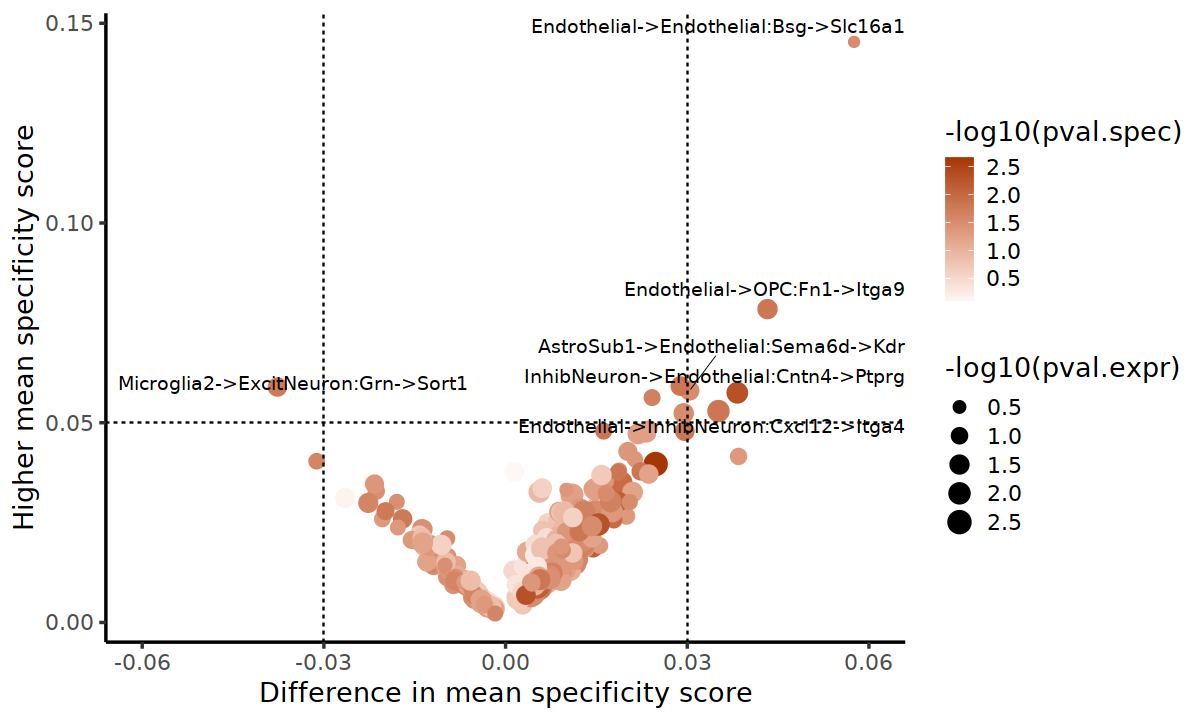

In [8]:
pval.th <- 0.05
spec.higher.th <- 0.05
spec.higher.th2 <- 0
spec.diff.th <- 0.03

p0 <- joined %>%
    filter(sign(logfc) == sign(diff)) %>%
    #filter(mean.1 > spec.higher.th2 | mean.2 > spec.higher.th2) %>%
    mutate(frac.ligand.higher = ifelse(logfc > 0, frac.ligand.1, frac.ligand.2), frac.receptor.higher = ifelse(logfc > 0, frac.receptor.1, frac.receptor.2)) %>%
    filter(frac.ligand.higher > 0.1, frac.receptor.higher > 0.1) %>%
    filter(pval.expr < pval.th | pval.spec < pval.th) %>%
    mutate(spec.higher = ifelse(logfc > 0, mean.1, mean.2), expr.higher = ifelse(logfc > 0, logmean.1, logmean.2)) %>%
    mutate(label1 = ifelse(
        ((pval.expr < pval.th & abs(diff) > spec.diff.th & spec.higher > spec.higher.th) | (pval.spec < pval.th & abs(diff) > spec.diff.th & spec.higher > spec.higher.th)) & logfc < 0  , 
        paste0(Sending.cluster, "->", Target.cluster, ':', Ligand.symbol, "->", Receptor.symbol), "")) %>%
    mutate(label2 = ifelse(
        ((pval.expr < pval.th & abs(diff) > spec.diff.th & spec.higher > spec.higher.th) | (pval.spec < pval.th & abs(diff) > spec.diff.th & spec.higher > spec.higher.th)) & logfc > 0  , 
        paste0(Sending.cluster, "->", Target.cluster, ':', Ligand.symbol, "->", Receptor.symbol), "")) 

options(repr.plot.width = 10, repr.plot.height = 6)
p <- ggplot(p0, aes(x = diff, y = spec.higher, size = -log10(pval.expr))) +
    geom_point(aes(color = -log10(pval.spec))) + 
    scale_color_gradient2(low = "#fdbe85", high = "#a63603") + 
    theme_classic(base_size = 16) +
    geom_text_repel(data = p0 %>% filter(label1 != ""), 
        aes(label = label1), 
        size = 4, 
        force = 10, 
        hjust = 1, 
        direction = 'y', 
        nudge_x = -0.1, 
        nudge_y = 0.001, 
        segment.size = 0.2, 
        max.overlaps = 100
    ) +
    geom_text_repel(data = p0 %>% filter(label2 != ""), 
        aes(label = label2), 
        size = 4, 
        force = 10, 
        hjust = 1, 
        direction = 'y', 
        nudge_x = 0.1, 
        nudge_y = 0.005, 
        segment.size = 0.2, 
        max.overlaps = 100
    ) +
    geom_vline(aes(xintercept = spec.diff.th), linetype = 'dashed') +
    geom_vline(aes(xintercept = -spec.diff.th), linetype = 'dashed') +
    geom_hline(aes(yintercept = spec.higher.th), linetype = 'dashed') +
    lims(x = c(-0.06, 0.06)) +
    labs(x = 'Difference in mean specificity score', y = 'Higher mean specificity score')

ggsave(filename = "../processed_data/211116_natmi_figures/NATMI-venDG.volcano.pdf", 
    plot = p, width = 10, height = 7.5)

p

## Plot top ligands

In [9]:
cts <- c('ExcitNeuron', 'InhibNeuron', 'Granule', 'Mossy', 
         'Oligodend1', 'Oligodend2', 'OPC', 'BergGlia', 
         'AstroSub1', 'Microglia1', 'Microglia2', 'Endothelial')

In [10]:
makeLogfc <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        select(Sending.cluster, Target.cluster, logfc) %>%
        pivot_wider(names_from = Target.cluster, values_from = logfc) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- 0
    return(mat)
}

makePvalExpr <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        select(Sending.cluster, Target.cluster, pval.expr) %>%
        pivot_wider(names_from = Target.cluster, values_from = pval.expr) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- 1
    return(mat)
}

makeDiff <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        select(Sending.cluster, Target.cluster, diff) %>%
        pivot_wider(names_from = Target.cluster, values_from = diff) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- 0
    return(mat)
}

makePvalSpec <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        select(Sending.cluster, Target.cluster, pval.spec) %>%
        pivot_wider(names_from = Target.cluster, values_from = pval.spec) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- 1
    return(mat)
}

makeFracFilter <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        mutate(frac.ligand.higher = ifelse(logfc > 0, frac.ligand.1, frac.ligand.2), frac.receptor.higher = ifelse(logfc > 0, frac.receptor.1, frac.receptor.2)) %>%
        mutate(frac.filter = frac.ligand.higher > 0.1 & frac.receptor.higher > 0.1) %>%
        select(Sending.cluster, Target.cluster, frac.filter) %>%
        pivot_wider(names_from = Target.cluster, values_from = frac.filter) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- F
    return(mat)
}

In [11]:
joined.f <- joined %>%
    filter(sign(logfc) == sign(diff)) %>%
    mutate(frac.ligand.higher = ifelse(logfc > 0, frac.ligand.1, frac.ligand.2), frac.receptor.higher = ifelse(logfc > 0, frac.receptor.1, frac.receptor.2)) %>%
    filter(frac.ligand.higher > 0.1, frac.receptor.higher > 0.1) %>%
    mutate(spec.higher = ifelse(logfc > 0, mean.1, mean.2), expr.higher = ifelse(logfc > 0, logmean.1, logmean.2), Treatment = ifelse(logfc > 0, 'FT', 'Sham')) %>%
    filter(abs(diff) > spec.diff.th & spec.higher > spec.higher.th) %>%    
    filter(pval.expr < pval.th | pval.spec < pval.th) %>%
    arrange(pval.expr)
top.lrs <- joined.f %>% distinct(Ligand.symbol, Receptor.symbol)
c(dim(joined.f), dim(top.lrs))

[1]  6 21  6  2

In [12]:
write.csv(joined.f, file = "../processed_data/211116_natmi_figures/NATMI-venDG.top_hits.csv")

In [20]:
ligands <- top.lrs$Ligand.symbol[6:6]
receptors <- top.lrs$Receptor.symbol[6:6]
lrs <- paste0(ligands, '->', receptors)
lrs <- factor(rep(lrs, each = length(cts)), levels = lrs)

logfc <- do.call(rbind, mapply(makeLogfc, ligands, receptors, SIMPLIFY = F))
pval.expr <- -log10(do.call(rbind, mapply(makePvalExpr, ligands, receptors, SIMPLIFY = F)))
diff <- do.call(rbind, mapply(makeDiff, ligands, receptors, SIMPLIFY = F))
pval.spec <- -log10(do.call(rbind, mapply(makePvalSpec, ligands, receptors, SIMPLIFY = F)))
frac.filter <- do.call(rbind, mapply(makeFracFilter, ligands, receptors, SIMPLIFY = F))

cm <- cividis(3)

col_fun = colorRamp2(c(-2, 0, 2), cm)
hm.expr <- Heatmap(logfc, cluster_rows = F, cluster_columns = F, 
    cluster_row_slices = F, row_names_side = 'left', 
    cluster_column_slices = F, column_names_side = 'top',
    rect_gp = gpar(type = "none"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.rect(x = x, y = y, width = width, height = height, 
            gp = gpar(col = "lightgrey", fill = NA))        
        grid.circle(x = x, y = y, r = 0.5 * pval.expr[i,j]/2.5 * unit(5, "mm"), 
        gp = gpar(col = NA, fill = ifelse(frac.filter[i,j], col_fun(logfc[i,j]), 'white')))           
    },     
    height = unit(5, "mm") * length(lrs), 
    width = unit(5, "mm") * length(cts),                    
    col = col_fun, column_title = 'Log difference in\n mean expression score', 
    name = 'Log difference in\n mean expression score',
    row_split = lrs)

col_fun2 = colorRamp2(c(-0.02, 0, 0.02), cm)
hm.spec <- Heatmap(diff, cluster_rows = F, cluster_columns = F, 
    cluster_row_slices = F, row_names_side = 'left', 
    cluster_column_slices = F, column_names_side = 'top',
    rect_gp = gpar(type = "none"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.rect(x = x, y = y, width = width, height = height, 
            gp = gpar(col = "lightgrey", fill = NA))        
        grid.circle(x = x, y = y, r = 0.5 * pval.spec[i,j]/2.5 * unit(5, "mm"), 
        gp = gpar(col = NA, fill = ifelse(frac.filter[i,j], col_fun2(diff[i,j]), 'white')))           
    },      
    col = col_fun2, column_title = 'Difference in\n mean specificity score', 
    height = unit(5, "mm") * length(lrs), 
    width = unit(5, "mm") * length(cts),     
    name = 'Difference in\n mean specificity score',
    row_split = lrs
)

lgd <- Legend(labels = c(0.5, 1, 2),
           title = "-log10 p-value",
           graphics = list(
              function(x, y, w, h) grid.circle(x, y, 
                                               r=0.5 * 0.5/2.5 * unit(5, "mm"),
                                               gp=gpar(fill="black")),
              function(x, y, w, h) grid.circle(x, y, 
                                               r=0.5 * 1/2.5 * unit(5, "mm"),
                                               gp=gpar(fill="black")),
              function(x, y, w, h) grid.circle(x, y, 
                                               r=0.5 * 2/2.5 * unit(5, "mm"),
                                               gp=gpar(fill="black"))
           ))

ht_list <- hm.expr + hm.spec

pdf(file = "../processed_data/211116_natmi_figures/NATMI-venDG.dotplot-2.pdf",
    width = 10, height = 15)
draw(ht_list, ht_gap = unit(5, "mm"), row_gap = unit(5, "mm"), 
     merge_legend = T, annotation_legend_list = list(lgd), 
     row_title = 'Sender', column_title = '               Receiver', 
     column_title_gp = gpar(fontsize = 16), row_title_gp = gpar(fontsize = 16))
dev.off()

png 
  2